Step 1: Load & initial audit

In [48]:
import pandas as pd
import numpy as np

# Step 1: Load & initial audit
file_path = "Airbnb_Open_Data.csv"

df = pd.read_csv(file_path)

df.head()

C:\Users\acer\AppData\Local\Temp\ipykernel_1284\243929437.py:7: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


Step 2: Duplicate Checking

In [49]:
# Step 2: Duplicate checking for listing id
id_dup_count = df["id"].duplicated().sum()
print(f"Duplicate id count: {id_dup_count}")

# Show sample duplicate ids if any
if id_dup_count > 0:
    dup_ids = df.loc[df["id"].duplicated(), "id"].head(10)
    print("Sample duplicate ids:", dup_ids.tolist())
else:
    print("No duplicate ids found.")


Duplicate id count: 541
Sample duplicate ids: [35506831, 35507383, 35507935, 35508488, 35509040, 35509592, 35510145, 35510697, 35511249, 35511802]


In [50]:
# Remove duplicate rows by listing id
before_rows = len(df)
df = df.drop_duplicates(subset=["id"]).reset_index(drop=True)
removed = before_rows - len(df)
print(f"Removed {removed} duplicate rows. Remaining rows: {len(df)}")


Removed 541 duplicate rows. Remaining rows: 102058


Step 3: Missing value checking

In [51]:
# Step 3: Missing value report
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
})

missing_summary

,missing_count
id,0
NAME,250
host id,0
host_identity_verified,289
host name,404
neighbourhood group,29
neighbourhood,16
lat,8
long,8
country,532


Step 4: Remove Outliner

In [52]:
# Clean 'minimum nights': set negative or >90 to NaN
min_nights_col = "minimum nights"
if min_nights_col in df.columns:
    df[min_nights_col] = pd.to_numeric(df[min_nights_col], errors="coerce")
    invalid_mask = (df[min_nights_col] < 0) | (df[min_nights_col] > 90)
    df.loc[invalid_mask, min_nights_col] = np.nan
    print(f"Set {invalid_mask.sum()} invalid '{min_nights_col}' values to NaN")
else:
    print(f"Column '{min_nights_col}' not found")

Set 437 invalid 'minimum nights' values to NaN


In [53]:
# Clean 'availability 365': set negative or >365 to NaN
avail_col = "availability 365"
if avail_col in df.columns:
    df[avail_col] = pd.to_numeric(df[avail_col], errors="coerce")
    invalid_mask = (df[avail_col] < 0) | (df[avail_col] > 365)
    df.loc[invalid_mask, avail_col] = np.nan
    print(f"Set {invalid_mask.sum()} invalid '{avail_col}' values to NaN")
else:
    print(f"Column '{avail_col}' not found")

Set 3185 invalid 'availability 365' values to NaN


Step 5: Preparation for Filling Missing Value

In [54]:
# Reformat price and service fee to plain numeric
money_cols = ["price", "service fee"]
for col in money_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")
        print(f"Reformatted '{col}' to numeric")
    else:
        print(f"Column '{col}' not found")

Reformatted 'price' to numeric
Reformatted 'service fee' to numeric


In [55]:
# Fix typos and standardize 'neighbourhood group'
ng_col = "neighbourhood group"

if ng_col in df.columns:
    ng_series = df[ng_col].astype("string")
    ng_clean_base = ng_series.str.strip()
    ng_lower = ng_clean_base.str.lower()

    ng_map = {
        "manhatan": "Manhattan",
        "manhatten": "Manhattan",
        "manhattan": "Manhattan",
        "brooklyn": "Brooklyn",
        "brookln": "Brooklyn",
        "queens": "Queens",
        "bronx": "Bronx",
        "staten island": "Staten Island",
        "statenisland": "Staten Island",
    }

    ng_fixed = ng_lower.map(ng_map).fillna(ng_clean_base.str.title())
    changed_mask = ng_series.notna() & (ng_lower != ng_fixed.str.lower())

    if changed_mask.any():
        print(f"Fixed {int(changed_mask.sum())} '{ng_col}' values")
        print("Before -> After (counts):")
        change_summary = (
            pd.DataFrame({
                "before": ng_series[changed_mask].fillna("<NA>"),
                "after": ng_fixed[changed_mask].fillna("<NA>"),
            })
            .value_counts()
            .reset_index(name="count")
        )
        change_summary
    else:
        print(f"No typos detected in '{ng_col}'")

    df[ng_col] = ng_fixed
else:
    print(f"Column '{ng_col}' not found")

Fixed 2 'neighbourhood group' values
Before -> After (counts):


Step 6: Filling Missing Value

In [56]:
# Fill missing values
string_cols = [
    "host_identity_verified",
    "neighbourhood group",
    "country",
    "instant_bookable",
    "cancellation_policy",
]
float_max_cols = ["Construction year", "review rate number"]
float_mean_cols = [
    "price",
    "service fee",
    "number of reviews",
    "minimum nights",
    "reviews per month",
    "calculated host listings count",
    "availability 365",
]

for col in string_cols:
    if col in df.columns:
        fill_value = df[col].dropna().max()
        df[col] = df[col].fillna(fill_value)
        print(f"Filled missing '{col}' with max value: {fill_value}")
    else:
        print(f"Column '{col}' not found")

for col in float_max_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        fill_value = df[col].max()
        df[col] = df[col].fillna(fill_value)
        print(f"Filled missing '{col}' with max value: {fill_value}")
    else:
        print(f"Column '{col}' not found")

for col in float_mean_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        fill_value = df[col].mean()
        df[col] = df[col].fillna(fill_value)
        print(f"Filled missing '{col}' with mean value: {fill_value}")
    else:
        print(f"Column '{col}' not found")


Filled missing 'host_identity_verified' with max value: verified
Filled missing 'neighbourhood group' with max value: Staten Island
Filled missing 'country' with max value: United States
Filled missing 'instant_bookable' with max value: True
Filled missing 'cancellation_policy' with max value: strict
Filled missing 'Construction year' with max value: 2022.0
Filled missing 'review rate number' with max value: 5.0
Filled missing 'price' with mean value: 625.355580438263
Filled missing 'service fee' with mean value: 125.0392493982414
Filled missing 'number of reviews' with mean value: 27.517948466257668
Filled missing 'minimum nights' with mean value: 7.112822438031634
Filled missing 'reviews per month' with mean value: 1.3754082792207791
Filled missing 'calculated host listings count' with mean value: 7.936936671286331
Filled missing 'availability 365' with mean value: 134.52848361696724


C:\Users\acer\AppData\Local\Temp\ipykernel_1284\1476786719.py:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(fill_value)


In [57]:
# Recheck missing values after cleaning
missing_summary_after = pd.DataFrame({
    "missing_count": df.isna().sum(),
})

missing_summary_after

,missing_count
id,0
NAME,250
host id,0
host_identity_verified,0
host name,404
neighbourhood group,0
neighbourhood,16
lat,8
long,8
country,0


Step 7: Total Price

In [58]:
# Add total price 
price_col = "price"
fee_col = "service fee"
if price_col in df.columns and fee_col in df.columns:
    df[price_col] = pd.to_numeric(df[price_col], errors="coerce")
    df[fee_col] = pd.to_numeric(df[fee_col], errors="coerce")
    df["total price"] = df[price_col] + df[fee_col]
    print("Created 'total price' as price + service fee")
else:
    print("Column 'price' or 'service fee' not found")

Created 'total price' as price + service fee


Step 8: Correlation Heatmap

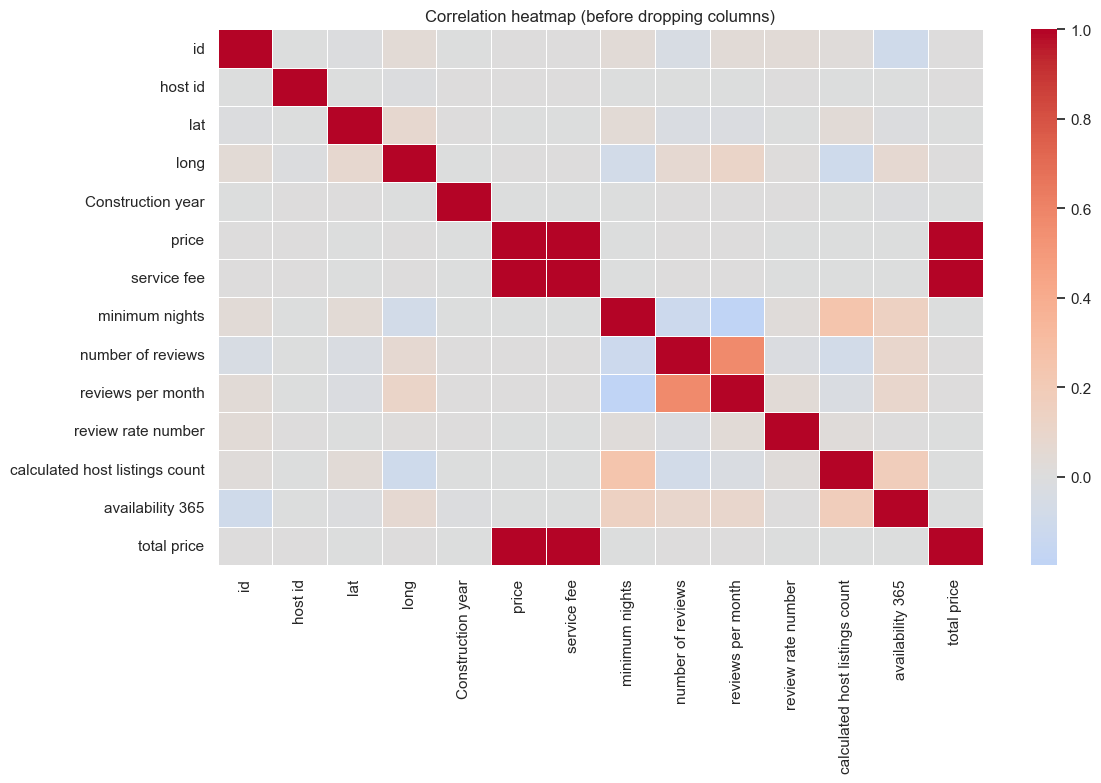

cleaned_data shape: (102058, 27)


In [59]:
# Correlation heatmap before dropping columns
import matplotlib.pyplot as plt
import seaborn as sns

numeric_df = df.select_dtypes(include=["number"])
corr = numeric_df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation heatmap (before dropping columns)")
plt.tight_layout()
plt.show()

# Keep all columns (no drop)
cleaned_data = df.copy()
print(f"cleaned_data shape: {cleaned_data.shape}")


In [60]:
# Drop identifier/location/text fields before saving
columns_to_drop = [
    "id",
    "name",
    "NAME",
    "host id",
    "host name",
    "neighbourhood",
    "lat",
    "long",
    "country code",
    "country",
    "house rule",
    "house_rules",
    "license",
]
cleaned_data = cleaned_data.drop(columns=columns_to_drop, errors="ignore")

# List attributes with data type and null count
attr_summary = pd.DataFrame({
    "dtype": cleaned_data.dtypes.astype(str),
    "null_count": cleaned_data.isna().sum(),
}).sort_index()

attr_summary

# Overwrite original CSV with cleaned data
output_path = "Airbnb_Open_Data_cleaned.csv"
cleaned_data.to_csv(output_path, index=False)
print(f"Saved cleaned_data to {output_path}")


Saved cleaned_data to Airbnb_Open_Data_cleaned.csv


Step 9: Visualisation

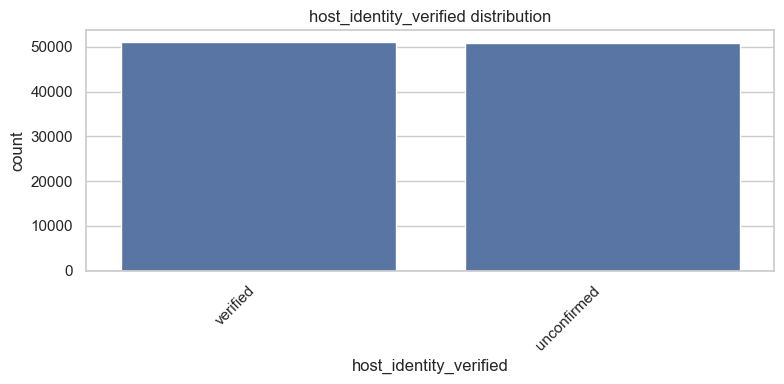

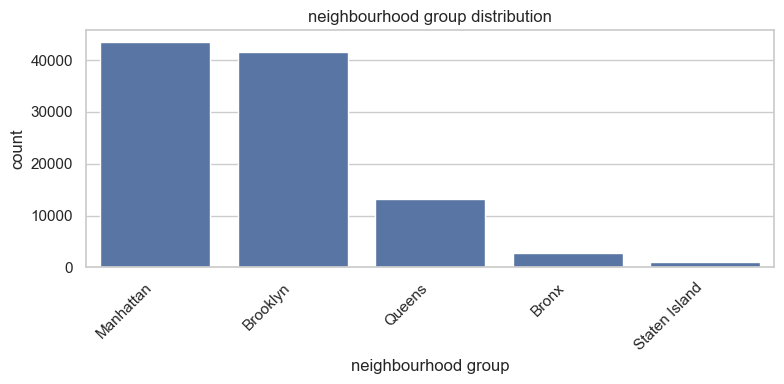

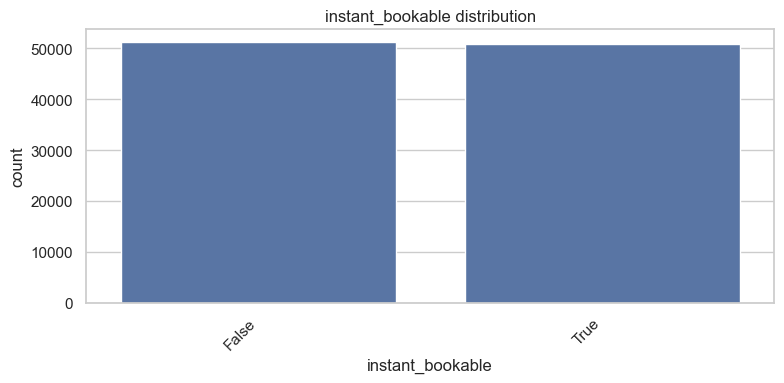

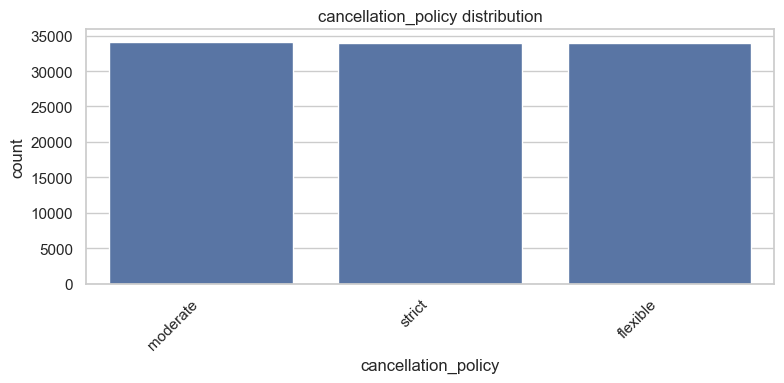

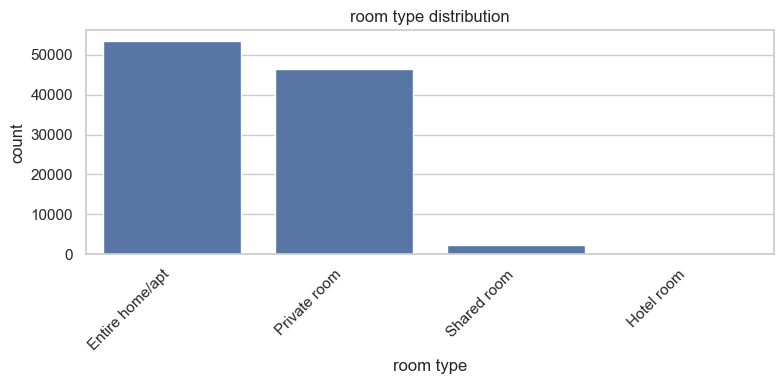

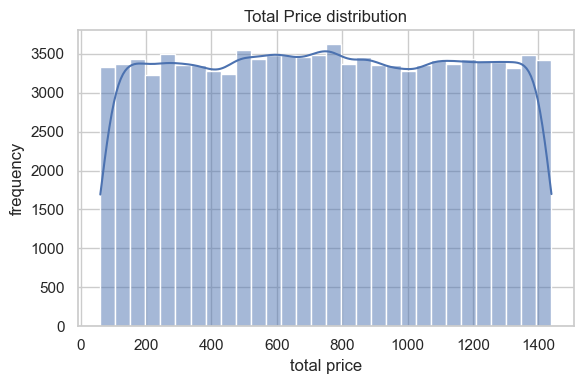

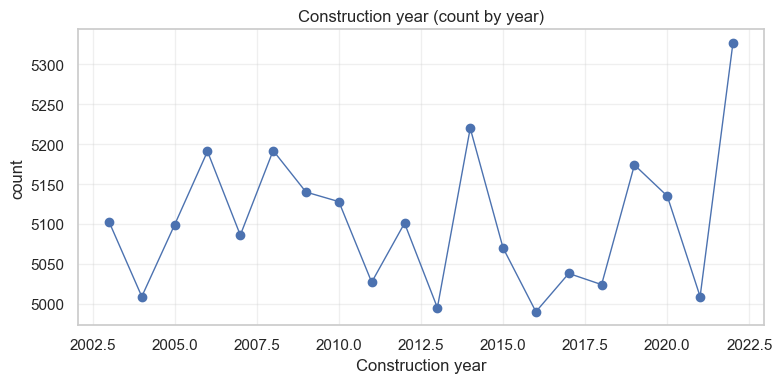

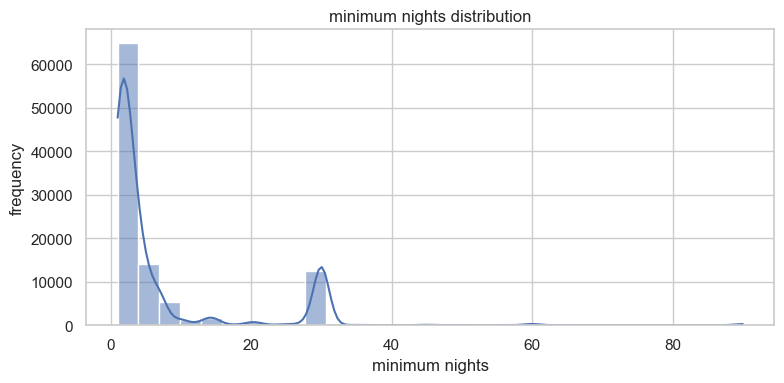

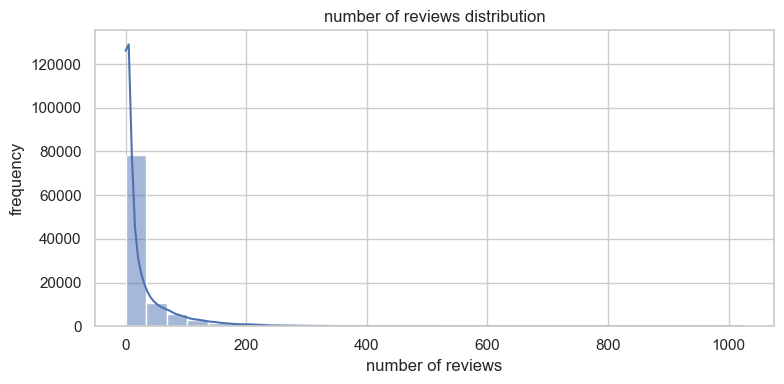

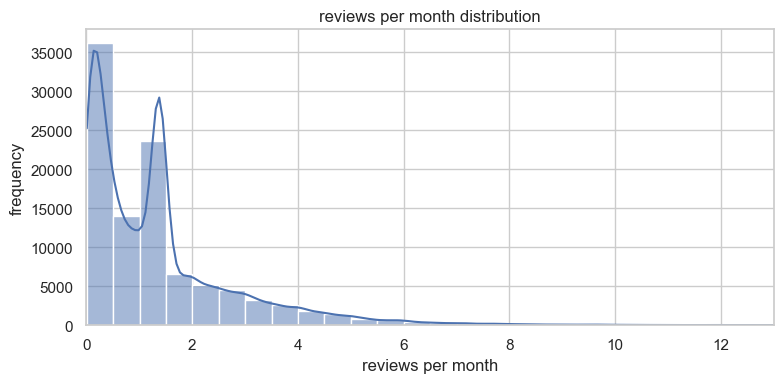

<Figure size 800x400 with 0 Axes>

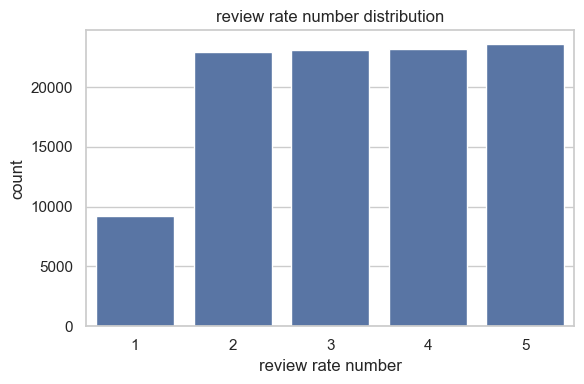

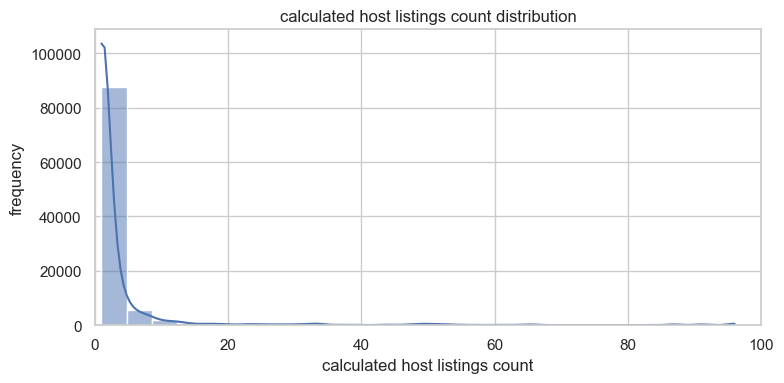

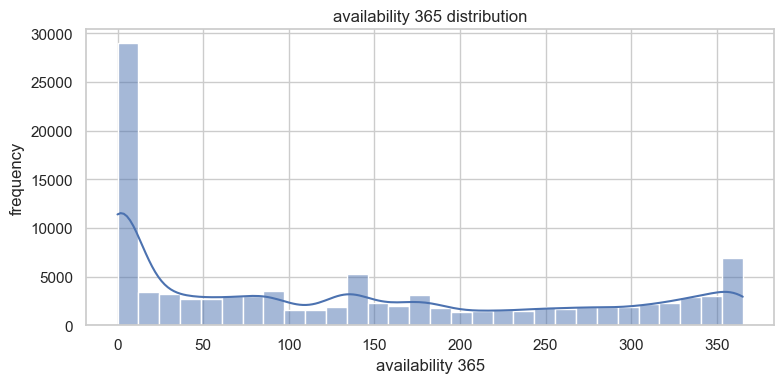

In [61]:
# Step 8: Visualizations for key attributes
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    sns = None

viz_df = cleaned_data if "cleaned_data" in globals() else df

categorical_cols = [
    "host_identity_verified",
    "neighbourhood group",
    "instant_bookable",
    "cancellation_policy",
    "room type",
]

numeric_cols = [
    "minimum nights",
    "number of reviews",
    "reviews per month",
    "review rate number",
    "calculated host listings count",
    "availability 365",
]

# Categorical plots
for col in categorical_cols:
    if col not in viz_df.columns:
        print(f"Column '{col}' not found, skipping.")
        continue

    plt.figure(figsize=(8, 4))
    counts = viz_df[col].astype("string").value_counts(dropna=False)
    if sns is not None:
        sns.barplot(x=counts.index.astype(str), y=counts.values)
    else:
        counts.plot(kind="bar")
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Total price distribution
total_col = "total price"
if total_col in viz_df.columns:
    total_series = pd.to_numeric(viz_df[total_col], errors="coerce")
elif price_col in viz_df.columns and fee_col in viz_df.columns:
    total_series = price_series + fee_series
else:
    total_series = None

if total_series is not None:
    plt.figure(figsize=(6, 4))
    if sns is not None:
        sns.histplot(total_series.dropna(), bins=30, kde=True)
    else:
        total_series.dropna().plot(kind="hist", bins=30)
    plt.title("Total Price distribution")
    plt.xlabel("total price")
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Total price/price/service fee columns not found, skipping total price plot.")

# Construction year
line_df = cleaned_data if "cleaned_data" in globals() else df
col = "Construction year"

if col not in line_df.columns:
    print(f"Column '{col}' not found, skipping.")
else:
    series = pd.to_numeric(line_df[col], errors="coerce").dropna()
    counts = series.value_counts().sort_index()

    plt.figure(figsize=(8, 4))
    plt.plot(counts.index, counts.values, marker="o", linewidth=1)
    plt.title("Construction year (count by year)")
    plt.xlabel("Construction year")
    plt.ylabel("count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Numeric plots
for col in numeric_cols:
    if col not in viz_df.columns:
        print(f"Column '{col}' not found, skipping.")
        continue

    plt.figure(figsize=(8, 4))
    series = pd.to_numeric(viz_df[col], errors="coerce")

    if col == "reviews per month":
        series = series[(series >= 0) & (series <= 13)]
        bins = 26
    elif col == "calculated host listings count":
        series = series[(series >= 0) & (series <= 100)]
        bins = 25
    elif col == "review rate number":
        series = series[(series >= 1) & (series <= 5)]
        bins = range(1, 7)
    else:
        bins = 30

    if col == "review rate number":
        counts = series.dropna().round(0).astype(int).value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        if sns is not None:
            sns.barplot(x=counts.index.astype(str), y=counts.values)
        else:
            counts.plot(kind="bar")
        plt.xticks(rotation=0)
        plt.title(f"{col} distribution")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()
        continue

    if sns is not None:
        sns.histplot(series.dropna(), bins=bins, kde=True)
    else:
        series.dropna().plot(kind="hist", bins=bins)

    if col == "reviews per month":
        plt.xlim(0, 13)
    if col == "calculated host listings count":
        plt.xlim(0, 100)

    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()
